# Plan

Use this notebook to see whether you can have unitary dynamics at a neural population level without responses of indivudal neurons coming out as periodic. As far as I can tell the answer is yes. This means that this analysis is not nonsense.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.optimize as op
import sys
import scipy as sp
import numba
from functools import partial
from mpl_toolkits import mplot3d
from sympy import Matrix
seaborn.set(font_scale=1.5,style='ticks')

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# Run with jax

In [2378]:
# Create shew symmetric matrix

dim = 4
nT = 9
x0 = np.random.normal(size=(dim,1))
A_ = np.random.normal(size=(dim,dim))

A = np.zeros([dim,dim])

for i in range(dim):
    A[i,i:] = A_[i:,i]
    A[i:,i] = -A_[i:,i]
    
A[np.diag_indices_from(A)] = 0
A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)

x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(9)])

In [4]:
Ahat = np.random.normal(size=(dim,dim))


In [5]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random


## These functions are not packaged in the mecll module I think..

In [6]:
def get_basis_tensor(dim):
    """ Returns a tensor that forms a basis for skew symmetric matrices.
        Use np.einsum('i...,i...',params,basis_tensor) to construct this
        matrix
    """
    basis_tensor = []
    for i in range(dim):
        for j in range(i+1,dim):
            bi =  np.zeros([dim,dim])
            bi[i,j] = -1
            bi = bi -bi.T
            basis_tensor.append(bi.T)
    basis_tensor = np.array(basis_tensor)
    return np.asarray(basis_tensor)


In [7]:
def construct_M(skewM,dim):
    """ Perform Caley transform"""
    return (jnp.eye(dim) - skewM)@jnp.linalg.inv(jnp.eye(dim)+skewM)

In [8]:
def predict(T,x,y,n,dim):
    transition_matrix = jnp.reshape(T,(dim,dim))
    return jnp.sum((jnp.dot(jnp.linalg.matrix_power(transition_matrix,n),x)-y)**2)


#predict_funs = [partial(predict,n=i,dim=dim) for i in range(9)]
#grad_predict_funs = [grad(i) for i in predict_funs]

In [9]:
def predict_all(params,x,dim,basis_tensor):

    err = 0
    nT = len(x)
    k = 0
    skewM = jnp.einsum('i...,i...',params,basis_tensor)
    M = construct_M(skewM,dim)
    #print(M.shape)
    for start_state in range(nT):
        for pred_state in range(start_state+1,nT-start_state):
            n_fwd = pred_state-start_state 
            err += predict(M,x[start_state],x[pred_state],n_fwd,dim)
            k += 1
    mse = err/k
    #print(mse)
    return mse


In [10]:
def grad_wrapper(params,x,dim,basis_tensor):
    grad = grad_predict_all(jnp.array(params),x,dim,basis_tensor)
    grad = np.array(grad)
    print(grad)
    return grad

In [11]:
def caley_transform(skewM,dim):
    """ Perform Caley transform"""
    return (np.eye(dim) - skewM)@np.linalg.inv(np.eye(dim)+skewM)

## Generate Data

# Generate activiy from a population dynamics matrix that are noisy in various ways

In [20]:
n_neurons = 120
dim = 8
nT = 9

frac_noise_dynamics = .6

x0 = np.random.normal(size=(dim,1))
x0_2 = np.random.normal(size=(dim,1))


a_params = np.random.normal(size=int(dim*(dim-1)/2))

# This is basis tensor used to construct the skew symmetric 
# matrix from a of approx n^2/2 params
basis_tensor = get_basis_tensor(dim)

#
skewM = np.einsum('i...,i...',a_params, basis_tensor)

# This is the dynamics matrix
A = caley_transform(skewM,dim)

#A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)
x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(nT)])
x_2 = np.array([np.linalg.matrix_power(A,i)@x0_2 for i in range(nT)])

x = frac_noise_dynamics*x + (1-frac_noise_dynamics)*np.random.normal(size=x.shape)
x_2 = frac_noise_dynamics*x_2 + (1-frac_noise_dynamics)*np.random.normal(size=x.shape)


# project from population activity to neural space
W = np.random.normal(size=(n_neurons,dim))

basis_tensor = get_basis_tensor(dim)

n_bases = basis_tensor.shape[0]

In [21]:
# check that the matrix is actually skew symmetric
assert np.all(skewM==-skewM.T)

In [22]:
def get_spatial_tuning(poke_pos,peak_loc,width):
    """"""
    #for i in range(9):
    distance_matrix = np.abs((poke_pos[peak_loc]-poke_pos)**2).sum(axis=1)
    fr = norm(scale=width).pdf(distance_matrix)
    return fr#distance_matrix
        
def get_task_tuning_line(seq,peak_loc,width):
    task_dists = np.abs(peak_loc-np.arange(9))
#     fr = norm(scale=width).pdf(task_dists)
    fr = np.sin(task_dists)
    return fr[seq]#task_dists[seq]#[task_dists[i] for i in seq]#fr#[fr[i] for i in seq]

In [23]:
from scipy.stats import norm


act_matrix = []
act_matrix2 = []
space_order2 = np.random.permutation(np.arange(9))
space_order2_inv = [list(space_order2).index(i) for i in range(9)]
for nix in range(n_neurons):
    
    frac_space = np.random.uniform(0,1)
    peak_space = np.random.randint(0,9)
    std_space = np.random.randint(1000,12000)
    
    lamda1 = get_spatial_tuning(poke_pos,peak_space,std_space)
    lamda1 = lamda1/np.max(lamda1)
    
    
    neuron_state_couple = np.random.normal(size=(dim))
    
    lamda2 = np.squeeze(x)@neuron_state_couple
    lamda2_2 = np.squeeze(x_2)@neuron_state_couple

    
    w1 = np.random.normal()
    w2 = np.random.normal()
    activity = frac_space*lamda1 + (1-frac_space)*lamda2 + np.random.normal(scale=.1,size=9)
    act_matrix.append(activity.copy())
    
    activity2 = frac_space*lamda1[space_order2] + (1-frac_space)*lamda2_2 + np.random.normal(scale=.1,size=9)
    act_matrix2.append(activity2.copy())
act_matrix = np.array(act_matrix).T
act_matrix2 = np.array(act_matrix2).T

In [24]:
np.linalg.norm(A,axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [25]:
evals, evecs = np.linalg.eig(A)

In [26]:
#Adash = Matrix(A)
#P,J = Adash.jordan_form()

In [27]:
x.shape

(9, 8, 1)

In [28]:
evals

array([ 0.99011958+0.1402256j ,  0.99011958-0.1402256j ,
       -0.31304353+0.94973878j, -0.31304353-0.94973878j,
       -0.89318305+0.44969328j, -0.89318305-0.44969328j,
       -0.74368943+0.66852526j, -0.74368943-0.66852526j])

In [31]:
# These define axes of rotation, see plot below. For more information see 
# the churchland jpca paper
u1 = (evecs[:,0] + evecs[:,1]).real
u2 = (1j*(evecs[:,0] - evecs[:,1])).real

0
1
2
3


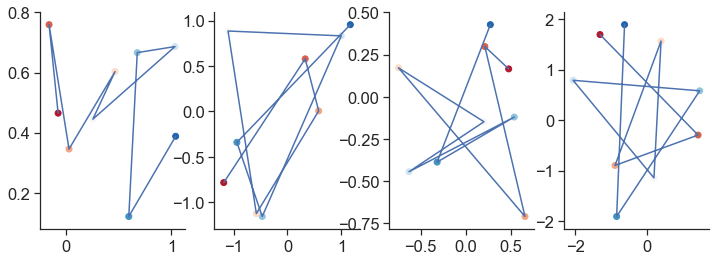

In [32]:
# 
u1 = (evecs[:,0] + evecs[:,1]).real
u2 = (1j*(evecs[:,0] - evecs[:,1])).real

plt.figure(figsize=(12,4))
offset = 0
if np.isreal(evals[0]): offset = 1
for i in range(int(np.floor(dim/2))):
    print(i)
    plt.subplot(1,4,i+1)
    ix0 = (2*i)     + offset
    ix1 = (2*i + 1) + offset
    u1 = (evecs[:,ix0] + evecs[:,ix1]).real
    u1 = u1/np.linalg.norm(u1)
    u2 = (1j*(evecs[:,ix0] - evecs[:,ix1])).real
    u2 = u2/np.linalg.norm(u2)
    w = np.vstack([u1,u2]).T
    projection = (np.squeeze(x)@w).T
    plt.plot(*(projection))
    plt.scatter(projection[0],projection[1],c=seaborn.color_palette("RdBu_r",n_colors=9))

seaborn.despine()

In [2411]:
def calculate_variance_explained_2(wx,x,cov=None):
    """
    USE THIS VERSION ITS MUCH CLEARER
    https://stats.stackexchange.com/questions/8630/principal-component-analysis-backwards-how-much-variance-of-the-data-is-expla
    """
    wx = np.reshape(wx,[-1,1])
    if cov is None:
        cov = np.cov(x)
    return (wx.T@cov@wx)/np.trace(cov)
    


In [2412]:
ix0 = 1
ix1 = 2
u1 = (evecs[:,ix0] + evecs[:,ix1]).real
u1 = u1/np.linalg.norm(u1)
u2 = (1j*(evecs[:,ix0] - evecs[:,ix1])).real
u2 = u2/np.linalg.norm(u2)


In [2413]:
(calculate_variance_explained_2(u1,np.squeeze(x).T) + 
 calculate_variance_explained_2(u2,np.squeeze(x).T) )


array([[0.17817201]])

In [2414]:
calcualte_variance_explained_by_projection(u1,np.squeeze(x).T)

array([[0.19242894]])

In [2415]:
def calcualte_variance_explained_by_projection(wx,x,cov=None):
    """ This is a bit strange it makes sense from a logical point
        of view in"""
    if cov is None:
        cov = np.cov(x)
    wx = np.reshape(wx,[-1,1])
    #print(np.linalg.norm(wx))
    #if 
    top = np.linalg.norm(cov@wx)**2 #the same as np.sum((cov@w[:,0])**2)
    bottom = (wx.T@cov@wx) * np.trace(cov)
    explained_variance_ratio = top/bottom
    
    return explained_variance_ratio

In [2416]:
np.corrcoef((np.squeeze(x)@w).T)

array([[1.        , 0.08976575],
       [0.08976575, 1.        ]])

In [2417]:
np.cov(np.squeeze(x)-np.mean(np.squeeze(x),axis=1)[:,None])[0]

array([ 0.43262474, -0.34355102, -0.16190569,  0.0140629 , -0.40527496,
        0.230341  , -0.12911486, -0.03887387,  0.14616951])

In [2418]:
(calcualte_variance_explained_by_projection(u1,np.squeeze(x).T) + 
 calcualte_variance_explained_by_projection(u2,np.squeeze(x).T)
)

array([[0.32280214]])

In [2419]:
from sklearn.decomposition import PCA

In [2420]:
pca = PCA(n_components=3)

In [2421]:
pca.fit_transform(np.squeeze(x))

array([[-1.38506663, -1.00627219, -0.49898514],
       [ 0.35210089,  1.60549878,  0.168991  ],
       [ 1.11768868, -0.97455342,  0.49102025],
       [-0.99903197,  0.97569592,  0.839349  ],
       [ 1.90870955,  0.54535274, -0.19872053],
       [-0.991162  , -0.22401629, -1.17404189],
       [-0.02271772,  0.83530029, -0.95395169],
       [ 1.02718207, -1.42984642,  0.03421186],
       [-1.00770285, -0.32715941,  1.29212714]])

In [2422]:
pca.explained_variance_ratio_[0]

0.3474112822395649

In [2423]:
calcualte_variance_explained_by_projection(wx=pca.components_[0],x=np.squeeze(x).T)

array([[0.34741128]])

In [2424]:
calcualte_variance_explained_by_projection(wx=pca.components_[0],x=np.squeeze(x).T)

array([[0.34741128]])

In [2425]:
w.shape

(8, 2)

In [2426]:
np.sum(pca.explained_variance_ratio_[0]*np.var(x,axis=0))

1.2207039859390312

In [2427]:
pca.explained_variance_ratio_[0]

0.3474112822395649

In [2428]:
calcualte_variance_explained_by_projection(wx=pca.components_[0],x=np.squeeze(x).T)

array([[0.34741128]])

In [2429]:
pca.explained_variance_[0]

1.3732919841814095

In [2430]:
cov.shape

(8, 8)

In [2431]:
w.shape

(8, 2)

In [2432]:
w.shape

(8, 2)

In [2433]:
x.shape

(9, 8, 1)

In [2434]:
cov = np.cov(np.squeeze(x).T)

np.linalg.norm(cov@w)/np.sum(np.trace(cov) + w.T@cov@w)

0.0719889605181796

In [2435]:
cov.shape

(8, 8)

In [2436]:
w.shape

(8, 2)

In [2437]:
evals, evecs = np.linalg.eig(A)

In [2438]:
real_evec = int(np.where(np.isreal(evals))[0])
nullspace = sp.linalg.null_space(evecs[:,real_evec].reshape(1,-1))
lns = np.linspace(-2,2,num=2)
xx, yy = np.meshgrid(lns,lns)
z = np.einsum('ij,klj->kli',nullspace,np.dstack([xx,yy])) + np.squeeze(np.mean(x,axis=0))[None,None]

# plot the plane
#ax.plot_surface(xx, yy, z, alpha=0.5)


TypeError: only size-1 arrays can be converted to Python scalars

In [2439]:
np.mean(x,axis=0)

array([[-0.11323042],
       [-0.10373033],
       [-0.10930366],
       [ 0.10621488],
       [ 0.10015522],
       [-0.15265093],
       [ 0.19033425],
       [ 0.12327401]])

In [2440]:
evals

array([ 0.54700136+0.83713172j,  0.54700136-0.83713172j,
        0.39902859+0.91693848j,  0.39902859-0.91693848j,
       -0.86841226+0.49584287j, -0.86841226-0.49584287j,
       -0.68045848+0.73278663j, -0.68045848-0.73278663j])

In [2441]:
(-1*nullspace[:,0] + -1*nullspace[:,1])

array([-0.03905586+0.j, -0.99275218+0.j, -1.0061655 +0.j,  0.01664151+0.j,
       -0.00206354+0.j,  0.01150217+0.j,  0.01162903+0.j])

In [2442]:
xx[0,0]

-2.0

In [2443]:
np.sum(-1*nullspace[:,0] + -1*nullspace[:,1])

(-2.0002643691856283+0j)

In [2444]:
np.allclose(0,evecs[:,0].reshape(1,-1)@nullspace)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 7 is different from 8)

In [2445]:
evals

array([ 0.54700136+0.83713172j,  0.54700136-0.83713172j,
        0.39902859+0.91693848j,  0.39902859-0.91693848j,
       -0.86841226+0.49584287j, -0.86841226-0.49584287j,
       -0.68045848+0.73278663j, -0.68045848-0.73278663j])

In [2446]:
nullspace

array([[ 0.26154011-0.j, -0.22248425-0.j,  0.60051501-0.j,
        -0.07446361-0.j,  0.41506011-0.j,  0.41963798-0.j],
       [ 0.95146453-0.j,  0.04128765-0.j, -0.11144095-0.j,
         0.01381863-0.j, -0.07702504-0.j, -0.07787458-0.j],
       [ 0.04128765-0.j,  0.96487784-0.j,  0.09479944-0.j,
        -0.01175509-0.j,  0.06552287-0.j,  0.06624554-0.j],
       [-0.11144095-0.j,  0.09479944-0.j,  0.74412353-0.j,
         0.03172858-0.j, -0.17685506-0.j, -0.17880566-0.j],
       [ 0.01381863-0.j, -0.01175509-0.j,  0.03172858-0.j,
         0.99606567-0.j,  0.02192995-0.j,  0.02217183-0.j],
       [-0.07702504-0.j,  0.06552287-0.j, -0.17685506-0.j,
         0.02192995-0.j,  0.87776246-0.j, -0.12358575-0.j],
       [-0.07787458-0.j,  0.06624554-0.j, -0.17880566-0.j,
         0.02217183-0.j, -0.12358575-0.j,  0.87505117-0.j]])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 8

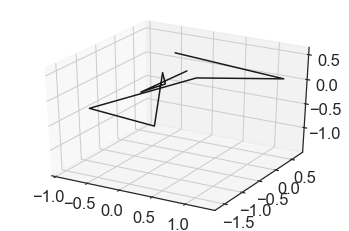

In [2447]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(x[:,0,0],x[:,1,0],x[:,2,0],color='k')

ax.plot3D(*np.vstack([np.zeros(3),evecs[:,real_evec]]).T,color='r')
#ax.plot3D(*np.vstack([np.zeros(3),evecs[:,1]]).T)
#ax.plot3D(*np.vstack([np.zeros(3),evecs[:,2]]).T)
ax.plot3D(*np.vstack([np.zeros(3),nullspace[:,0].real]).T,color='g')
ax.plot3D(*np.vstack([np.zeros(3),nullspace[:,1].real]).T,color='g')

#ax.set_xlim(-1,1)
#ax.set_ylim(-1,1)
#ax.set_zlim(-1,1)
ax.plot_surface(z[:,:,0],z[:,:,1],z[:,:,2], alpha=0.5)

plt.show()

# check if simulated unitary population dynamics produce periodic activity at the single cell level

In [2448]:
@numba.jit(nopython=True)
def fit_sin2(x,*params):
    t_ = np.linspace(0,2*np.pi,9)
    y = np.array(params)
    y -= np.mean(y)
    y /=np.max(y)
    pred = np.cos(x[0]*t_ + x[1])#*x[2] + x[3]
    cc = np.corrcoef(pred,y)[0,1]
    if np.isnan(cc): cc = -100
    return -cc

In [2449]:
resps_state_g1 = act_matrix.copy().T
resps_state_g2 = act_matrix2.copy().T

In [2450]:
res_t1 = []
res_t2 = []
all_cc = []
all_shuffle_cc = []
t_ = np.linspace(0,2*np.pi,9)
NSHUFF = 100
params_ranges = [slice(0,4,.5),slice(0,2*np.pi,np.pi/9)]
#params_ranges = [slice(0,4,.5),slice(0,np.pi,np.pi/9),slice(0,1,.25),slice(0,1,.25)]


n_neurons = resps_state_g1.shape[0]



for i in range(n_neurons):
    sys.stdout.write('\r running cell:{}'.format(i))
    sys.stdout.flush()
    
    y1 = resps_state_g1[i] #np.random.permutation(resps_state_g1[i])
    y2 = resps_state_g2[i] #np.random.permutation(resps_state_g2[i])
    spks = y1# - (y1 + y2)/2.
    y = spks
    #y -= np.mean(y)
    #y /=np.max(y)

    #res1 = op.minimize(fit_sin,
    #        [1,0],
    #        args=spks)
    res1 = op.brute(fit_sin2,params_ranges,args=spks,finish=None)
    cc1 = np.corrcoef(spks,np.cos(res1[0]*t_ + res1[1]))[0,1]
    
    cc1_shuff = []
    for _ in range(NSHUFF):
        spks_shuff = np.random.permutation(spks)
        res1_shuff = op.brute(fit_sin2,params_ranges,args=spks_shuff,finish=None)
        cc1_shuff.append(np.corrcoef(spks_shuff,np.cos(res1_shuff[0]*t_ + res1_shuff[1]))[0,1])
        


    spks = y2# - (y1 + y2)/2.
    y = spks
    #y = np.random.permutation(spks)
    #y -= np.mean(y)
    #y /=np.max(y)


    #res2 = op.minimize(fit_sin,
    #        [1,0],
    #        args=spks)
    res2 = op.brute(fit_sin2,params_ranges,args=spks,finish=None)
    cc2 = np.corrcoef(y,np.cos(res2[0]*t_ + res2[1]))[0,1]
    
    cc2_shuff = []
    for _ in range(NSHUFF):
        spks_shuff = np.random.permutation(spks)
        res2_shuff = op.brute(fit_sin2,params_ranges,args=spks_shuff,finish=None)
        cc2_shuff.append(np.corrcoef(spks_shuff,np.cos(res2_shuff[0]*t_ + res2_shuff[1]))[0,1])

    all_cc.append([cc1,cc2])
    all_shuffle_cc.append([cc1_shuff,cc2_shuff])
    
    res_t1.append(res1)
    res_t2.append(res2)
all_cc = np.array(all_cc)
res_t1 = np.array(res_t1)
res_t2 = np.array(res_t2)

 running cell:119

In [2451]:
import scipy.stats as stt

In [2452]:
p_vals = []
for cell_ix,cell in enumerate(all_cc):
    tmp = []
    for task_nr in range(2):
        p1 = stt.percentileofscore(all_shuffle_cc[cell_ix][task_nr],cell[task_nr])
        tmp.append(p1)
    p_vals.append(tmp)

In [2453]:
print(np.mean(np.array(p_vals)[:,0]>97.5))
print(np.mean(np.array(p_vals)[:,1]>97.5))

0.03333333333333333
0.10833333333333334


In [2454]:
np.where(np.array(p_vals)[:,0]>97.5)

(array([27, 31, 49, 65]),)

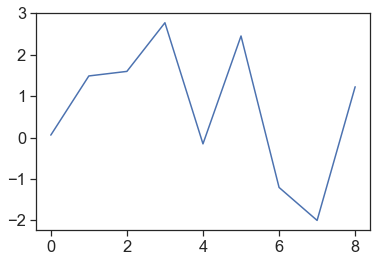

In [2455]:
plt.plot(act_matrix[:,111])

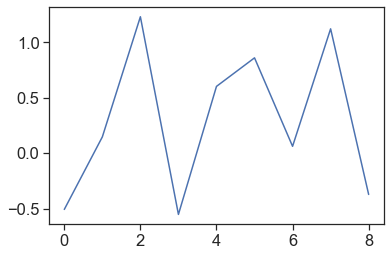

In [2456]:
plt.plot(act_matrix[:,5])

[[ 1.         -0.06231568]
 [-0.06231568  1.        ]]


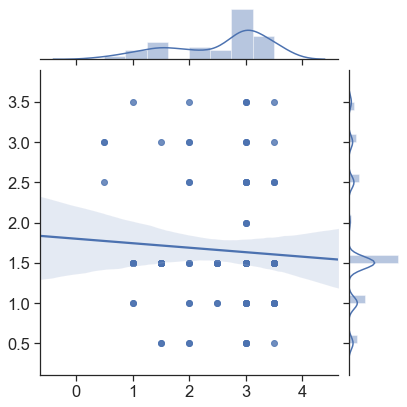

In [2457]:
seaborn.jointplot(res_t1[:,0],res_t2[:,0],kind='reg')
print(np.corrcoef(res_t1[:,0],res_t2[:,0]))